In [1]:
import os, sys
sys.path.append('../src')
sys.path.append('../src/utils/')
from spiking_dataloader import WISDM_spiking_dataloader, WisdmDatasetParser
from AHPC_network.AHPC_network_h1_test import AHPCnetwork
from lava.proc.io.sink import RingBuffer as SinkRingBuffer
from lava.proc.io.source import RingBuffer as SourceRingBuffer
from output_process import OutputProcess
from lava.proc.monitor.process import Monitor
import matplotlib.pyplot as plt
import numpy as np


In [2]:
dataset = WisdmDatasetParser('../data/data_watch_subset_0_40.npz', norm=None, class_sublset='custom', subset_list=[0, 2, 6, 8, 9, 14, 17])

(6,)
(6,)
ytrain shape (55404, 18)
yval shape (18468, 18)
ytest shape (18469, 18)
num classes train dataset: 7 occurrences of each class:[3127 2855 3102 3047 3150 2973 3213]
num classes eval dataset: 7 occurrences of each class:[1035  935 1122  996 1110 1007 1077]
num classes test dataset: 7 occurrences of each class:[1046  900 1046 1036 1076  982 1054]


In [3]:
num_samples = 100 

In [4]:
val_set = dataset.get_validation_set(subset=num_samples)
val_set[0].shape

(100, 6, 40)

In [5]:
spiking_loader = WISDM_spiking_dataloader(val_set , net_delay=4)

In [6]:
net = AHPCnetwork('../models/network_best.npz')
net.print_state_variables()

leaky1 betas:0.3261461853981018
leaky1 vth:1.9845956563949585
leaky2 betas:0.8115220665931702
leaky2 vth:1.0197168588638306
recurrent betas:0.5234979391098022
leaky3 betas:[1.]
leaky3 vth:0.6436737179756165
recurrent beta:0.5234979391098022
###network state variables###
leaky1_betas: 0.6738538146018982
leaky1_vth: 1.9845956563949585
leaky2_betas: 0.18847793340682983
leaky2_vth: 1.0197168588638306
leaky3_betas: [0.]
leaky3_vth: 0.6436737179756165



In [7]:
signal_data = np.random.rand(6, 80) * 1
input_data = SourceRingBuffer(data = val_set[0][0,:,:])
#input_data = SourceRingBuffer(data = np.ones((6,80))*2)
out_sink = SinkRingBuffer(shape=(7,),buffer=80)
b_sink = SinkRingBuffer(shape=(350,),buffer=80)
f_sink = SinkRingBuffer(shape=(350,),buffer=80)
print(val_set[1][0])

2


In [8]:
input_data.s_out.connect(net.a_in)
net.s_out.connect(out_sink.a_in)
net.b_out.connect(b_sink.a_in)
net.f_out.connect(f_sink.a_in)

In [9]:

from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg, Loihi2SimCfg
import numpy as np
from tqdm import tqdm


out_sink.run(condition=RunSteps(num_steps=80),
                run_cfg=Loihi1SimCfg(select_sub_proc_model=True,
                select_tag='floating_pt'))
net.reset_hidden_state()




leaky1 dv:1
leaky1 du:0.6738538146018982
leaky1 vth:1.9845956563949585
leaky2 dv:1
leaky2 du:0.18847793340682983
leaky2 vth:1.0197168588638306
recurrent du:0.47650206089019775
leaky3 dv:1
leaky3 du:[0.]
leaky3 vth:0.6436737179756165


In [10]:

out_data = np.array(out_sink.data.get())
b_data = np.array(b_sink.data.get())
f_data = np.array(f_sink.data.get())

In [11]:
def create_raster_plot(data, figsize):
    plt.clf()
    plt.figure(figsize=figsize)
    print(data.shape)
    for channel in range(data.shape[0]):
        spike_times = np.where(data[channel])[0]
        plt.vlines(spike_times, channel + 0.5, channel + 1.5)

    plt.yticks(np.arange(0, data.shape[0] + 1), [f'N {i}' for i in range(0, data.shape[0]+1)])
    plt.xlabel('Time (ms)')
    plt.ylabel('Channels')
    plt.title('Raster Plot of Spiking Events')
    plt.ylim(0, data.shape[0])
    plt.xlim(0, data.shape[1])
    plt.xticks(ticks=np.arange(data.shape[1]), labels=np.arange(data.shape[1]))
    plt.grid(axis='x', color='black', linestyle='--', linewidth=0.2)
    plt.show()


# Generate the raster plot

def plot_signals(matrix, figsize):
    """
    Plots the signal for each channel in the provided matrix.
    
    Parameters:
    matrix (np.ndarray): A 2D array where the first dimension represents channels
                         and the second dimension represents timesteps.
    """
    channels, timesteps = matrix.shape
    
    plt.figure(figsize=figsize)
    for i in range(channels):
        plt.plot(matrix[i], label=f'Channel {i+1}')
    plt.xlabel('Timestep')
    plt.ylabel('Signal Value')
    plt.xlim(0, matrix.shape[1])
    plt.xticks(ticks=np.arange(matrix.shape[1]), labels=np.arange(matrix.shape[1]))
    plt.grid(axis='x', color='black', linestyle='--', linewidth=0.2)
    plt.legend()
    plt.show()



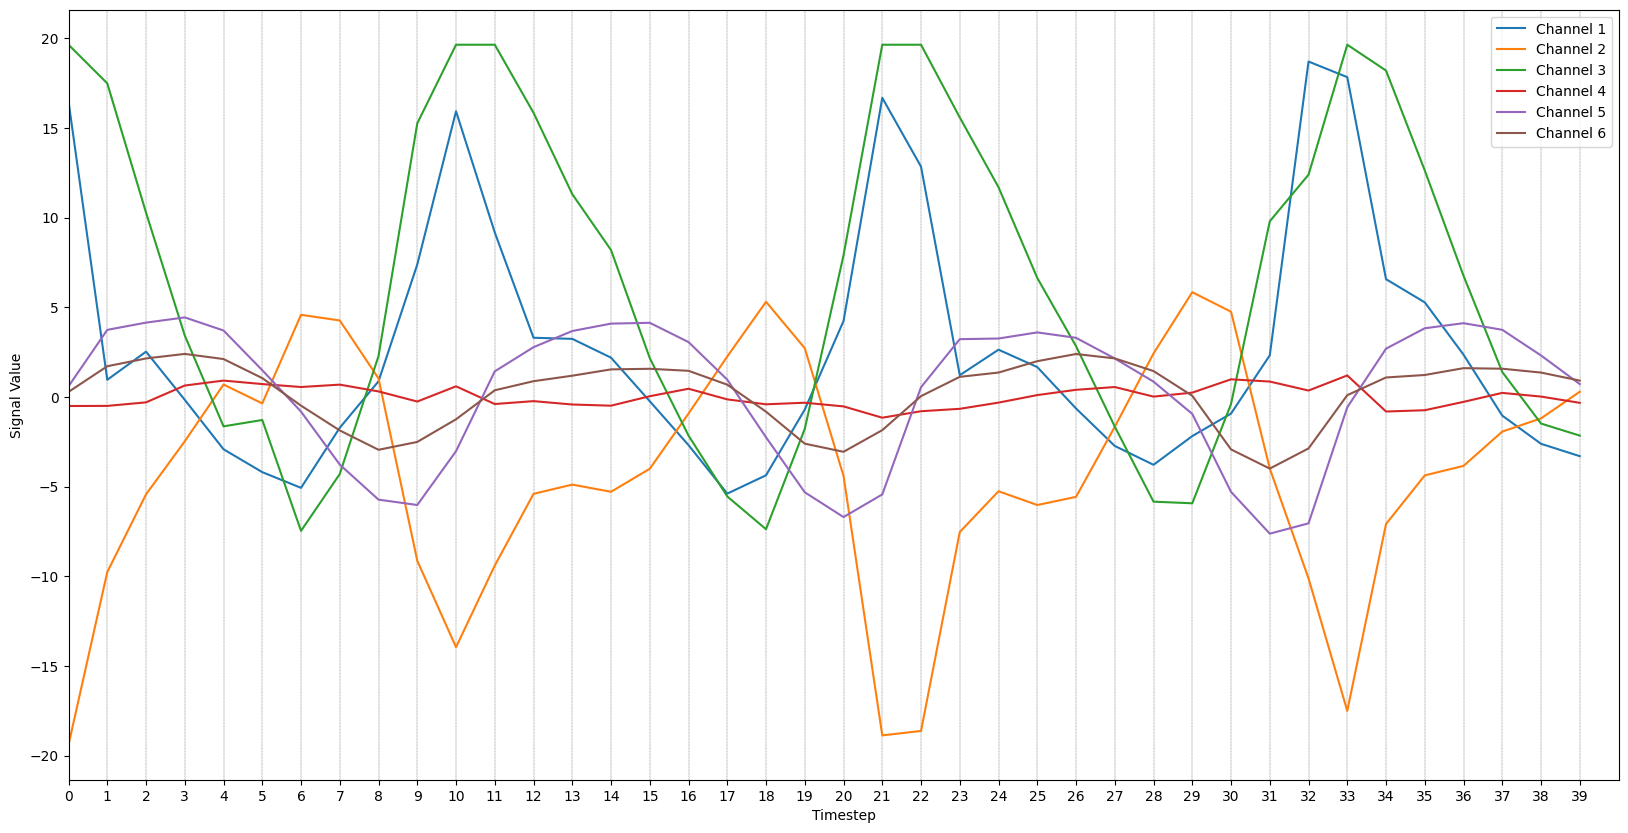

In [12]:
plot_signals(val_set[0][0,:,:], (20,10))

(350, 80)


<Figure size 640x480 with 0 Axes>

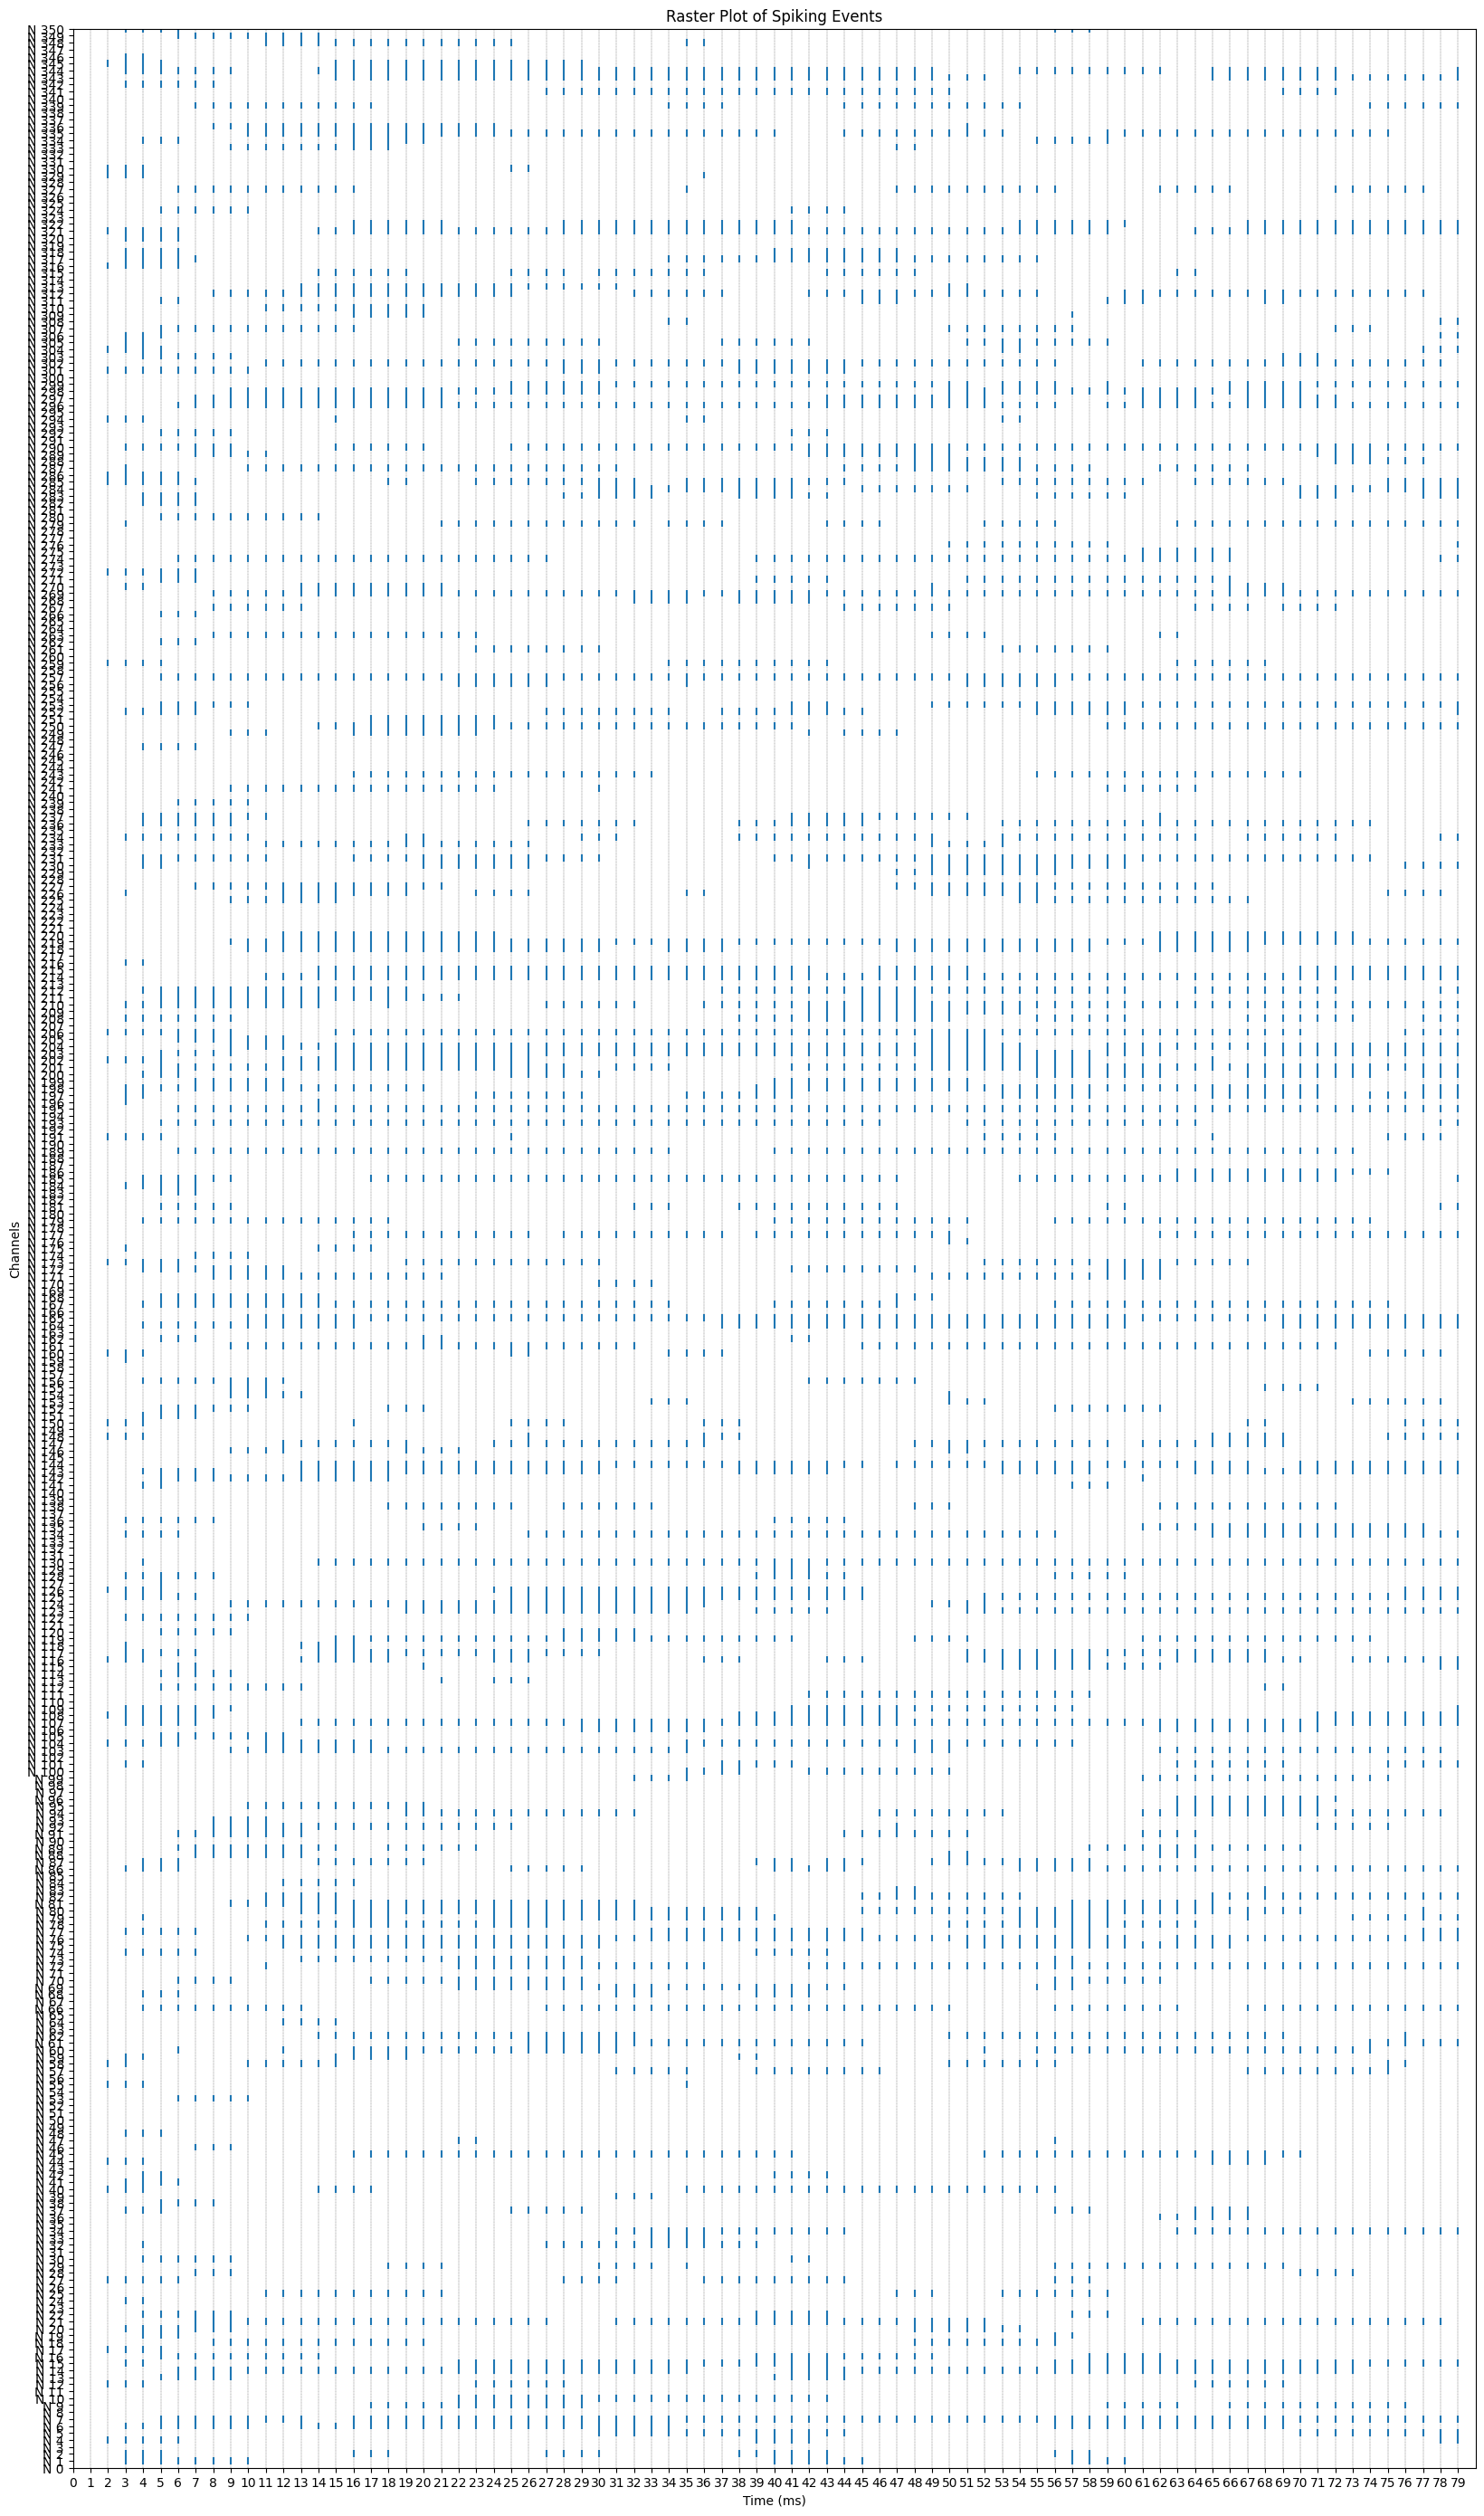

In [13]:
create_raster_plot(f_data, (20,35))


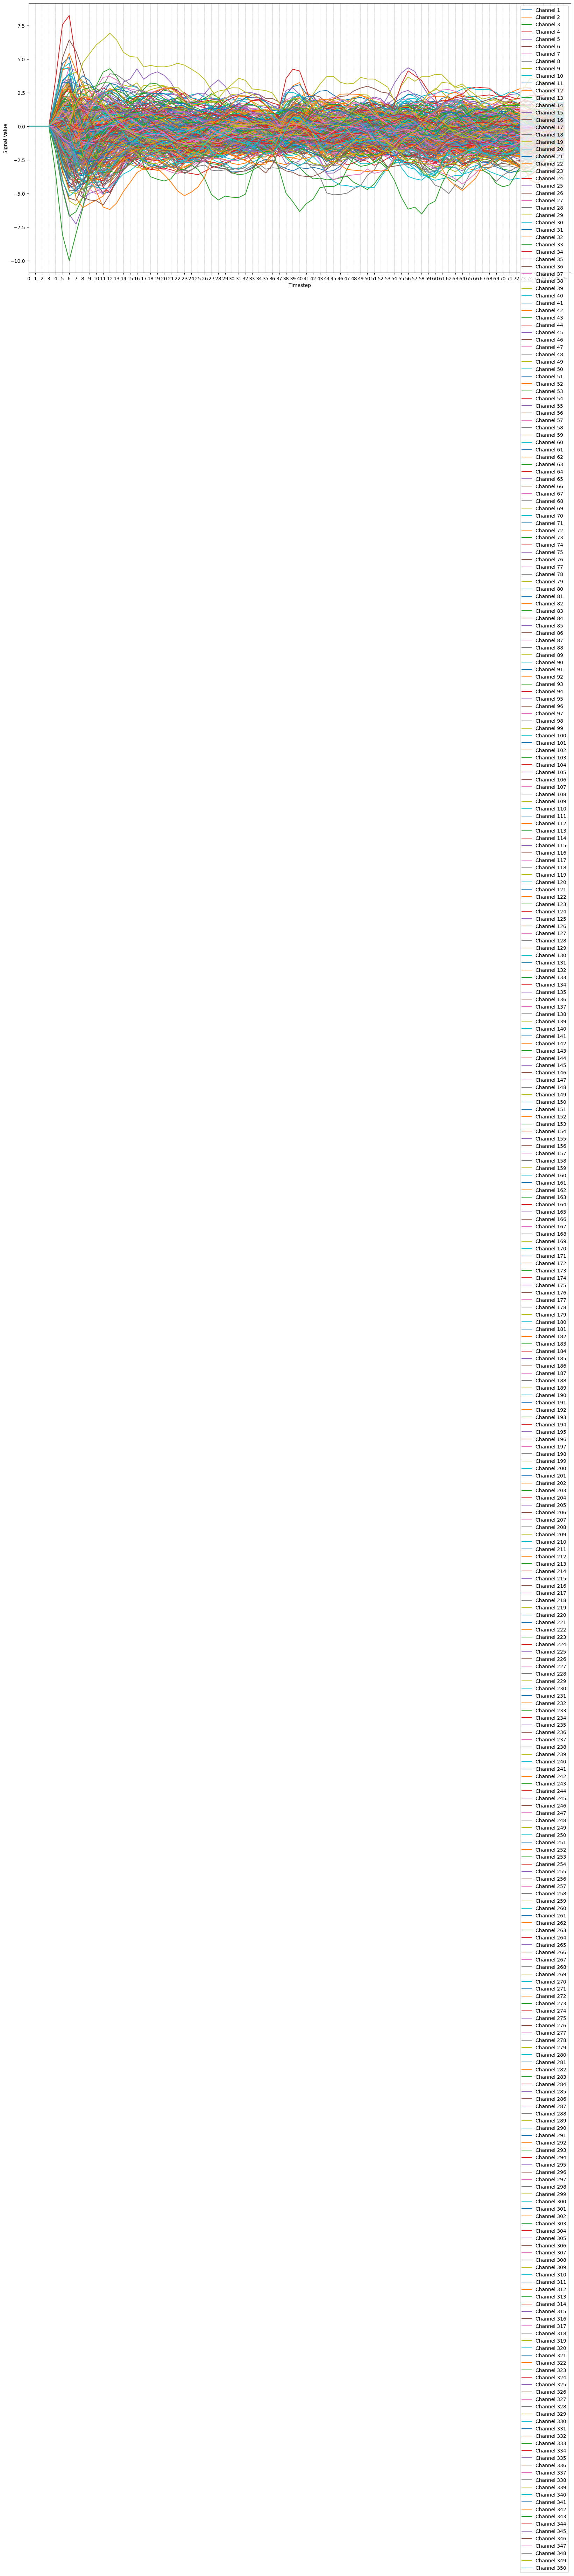

In [14]:
plot_signals(b_data, (20,10))


(7, 80)


<Figure size 640x480 with 0 Axes>

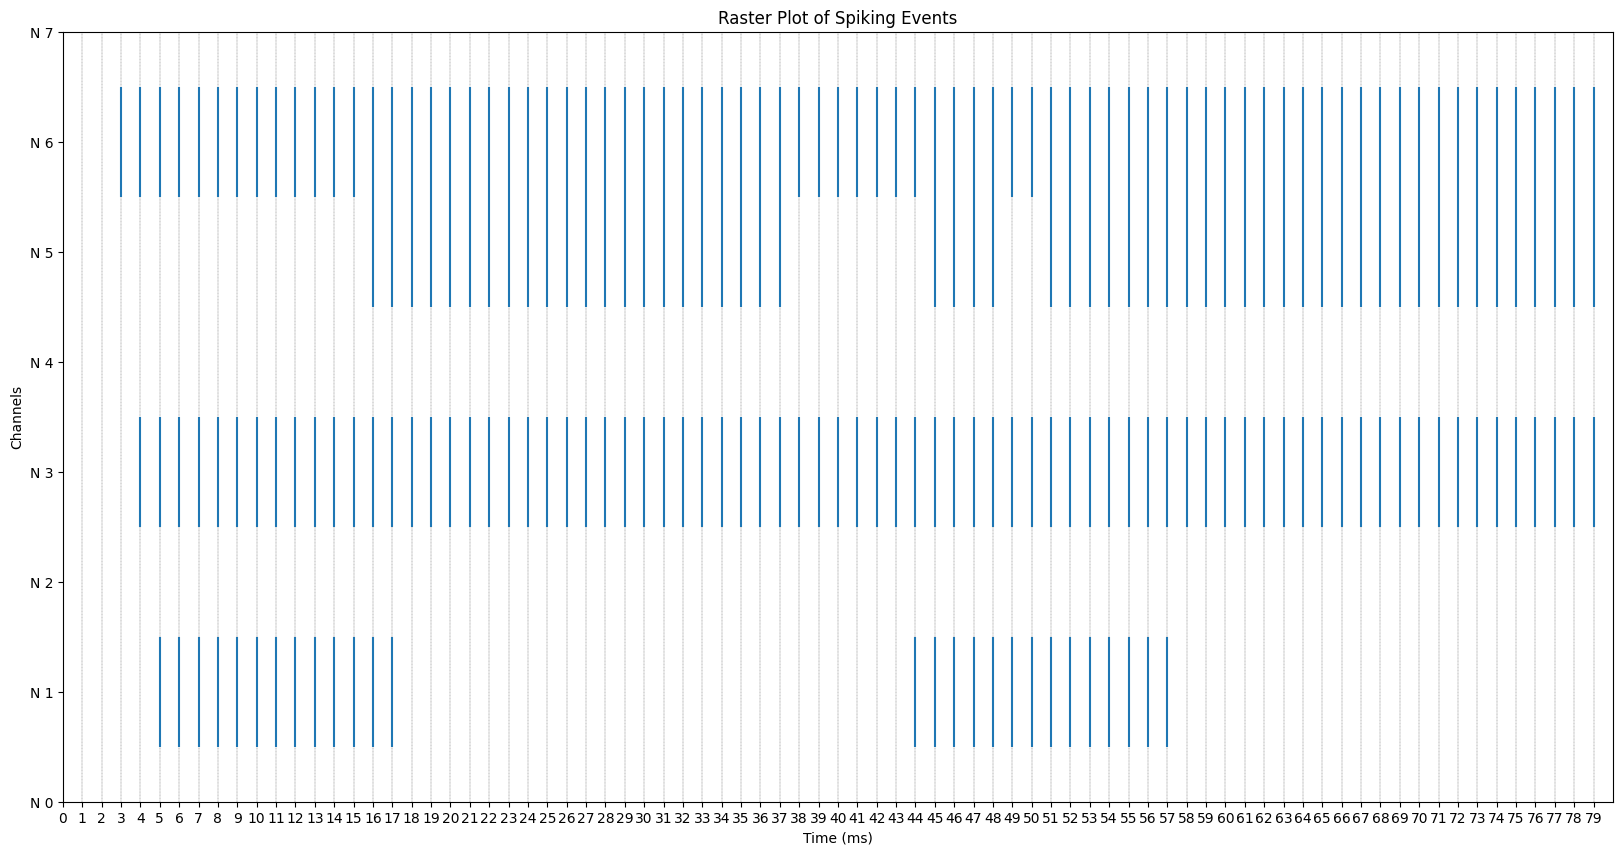

In [15]:
create_raster_plot(out_data, (20, 10))
